**Machine Learning Tutorial using Physicochemical Properties of Protein Tertiary Structure Data Set**

The workflow followed here is adapted from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://g.co/kgs/bvvihi) by **Aurélien Geron**.

*The dataset is downloaded from this link [Physicochemical Properties of Protein Tertiary Structure Data Set](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).* 

*The tutorial is divided into three sections:*
> 1. *Data preprocessing. Explore the dataset for statistical attributes*
> 2. *Fit a linear model and evaluate performance*
> 3. *Project the feature space onto a reduced one with at least 99% of variance preserved*
> 4. *Fit a linear model on the reduced features and evaluate performance*

# Exploratory Data Analysis and Preprocessing

Load all the relevant modules. Load the data into pandas dataframe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('default')
%matplotlib inline

In [2]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


Let us start with collecting all the useful statistics from the dataset. These built-in pandas functions will be very useful for this

In [3]:
casp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB


In [4]:
casp.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


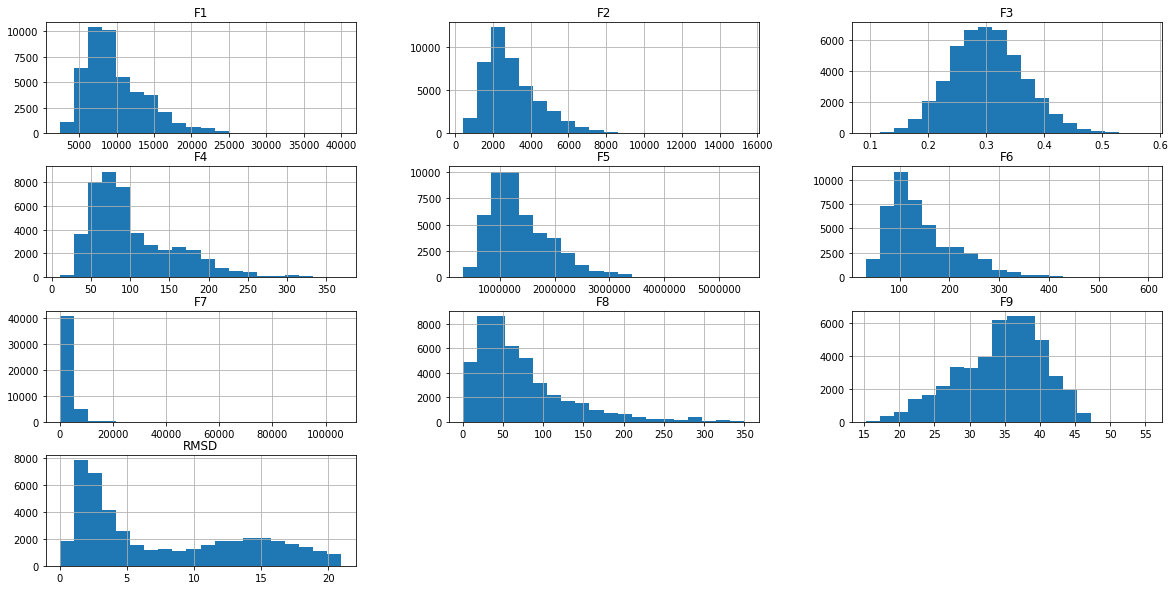

In [5]:
casp.hist(bins=20, figsize=(20,10));

One thing we notice is that, F7 has tail heavy distribution. We will need to deal with it. Let us see if there is any missing data in the dataset

In [6]:
np.any(casp.values == np.nan)

False

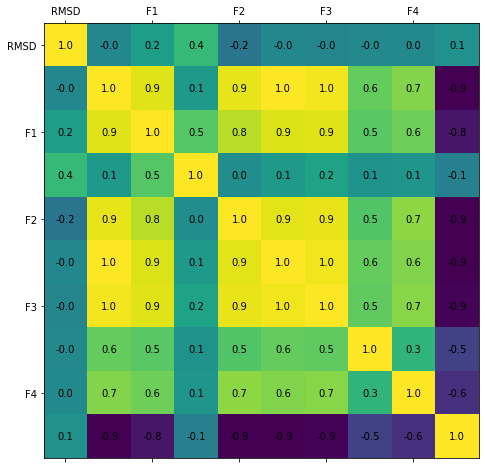

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), interpolation='none')

for (i, j), value in np.ndenumerate(casp.corr()):
    plt.text(i, j, f"{value:.1f}", va="center", ha="center")

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

In [8]:
casp.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374309
F2      0.156895
F9      0.062830
F8      0.000344
F7     -0.003339
F5     -0.013982
F1     -0.015087
F6     -0.036135
F4     -0.169771
Name: RMSD, dtype: float64

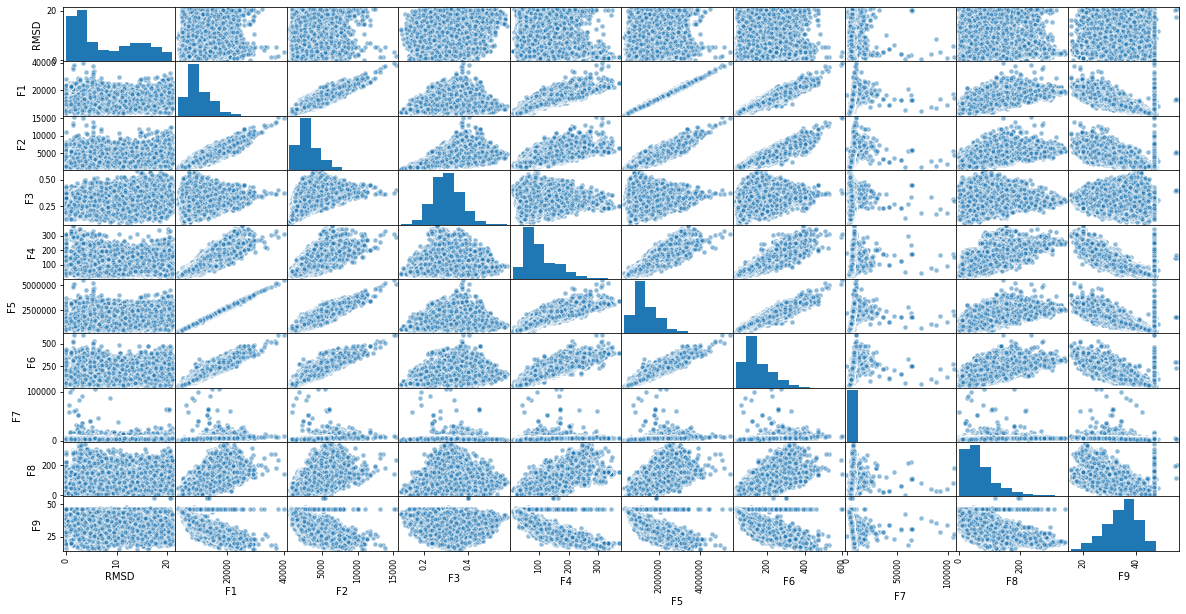

In [9]:
pd.plotting.scatter_matrix(casp, figsize=(20,10), edgecolors='w', s=100);

Let us spend some time on this plot and discuss what we see:

1. The target value in this case, `RMSD` is not seen to be linearly correlating with any of the features. 
2. Some of the features are very well correlated with each other. For example, `F1`, `F2`, `F4`, `F5` and `F6` seems to positively correlated. It is worthwhile to spend time in reducing the dimensionality of this data for better results.
3. From the correlations plots, let us pay more attention to feature `F9`. It can be easily noted that the values near ~50 have been capped artificially. Similarly For `RMSD`, the data is artificially capped close to 0.1. It is suggested to take a closer look at the data collection method. At this point, it is good to get rid of this data.
4. If you pay more attention to `F7`, you will notice that this is a highly tail-heavy distribution and it would be worthwhile to explore more about this.

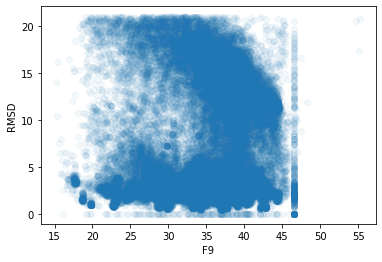

In [10]:
plt.scatter(casp["F9"], casp["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

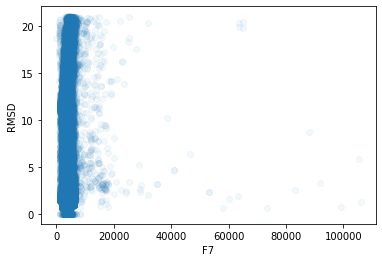

In [11]:
plt.scatter(casp["F7"], casp["RMSD"], alpha=0.05);
plt.xlabel("F7");
plt.ylabel("RMSD");

Let us for now get rid of this spurious data

In [12]:
casp_cleaned = casp[casp['F9']<46]
casp_cleaned = casp_cleaned[casp_cleaned["RMSD"] > 0.1]
casp_cleaned = casp_cleaned.reset_index().drop("index", axis=1)
casp_cleaned = casp_cleaned[casp_cleaned["F7"] < 8000]
casp_cleaned = casp_cleaned[casp_cleaned["F7"] >0.2]

In [13]:
casp_cleaned = casp_cleaned.reset_index()

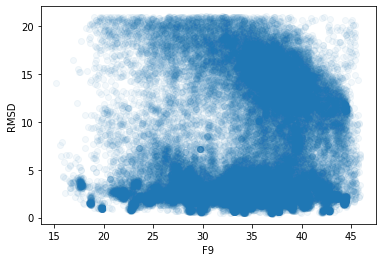

In [14]:
plt.scatter(casp_cleaned["F9"], casp_cleaned["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

In [15]:
min(casp_cleaned["F3"]),max(casp_cleaned["F3"])

(0.0925, 0.5776899999999999)

In [16]:
casp_cleaned["F3_cat"] = pd.cut(casp_cleaned["F3"], 
                                bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, np.inf],
                                labels = [1, 2, 3, 4, 5, 6])

In [17]:
casp_cleaned["F3_cat"].value_counts()/len(casp_cleaned)

3    0.455119
4    0.433048
5    0.064825
2    0.044769
6    0.002171
1    0.000067
Name: F3_cat, dtype: float64

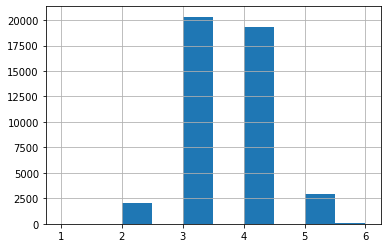

In [18]:
casp_cleaned["F3_cat"].hist()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(casp_cleaned, casp_cleaned["F3_cat"]):
    casp_train_set = casp_cleaned.loc[train_index]
    casp_test_set = casp_cleaned.loc[test_index]

In [20]:
casp_train_set["F3_cat"].value_counts()/len(casp_train_set)

3    0.455105
4    0.433056
5    0.064831
2    0.044769
6    0.002182
1    0.000056
Name: F3_cat, dtype: float64

In [21]:
for set_ in (casp_train_set, casp_test_set):
    set_.drop("F3_cat", axis=1, inplace = True)

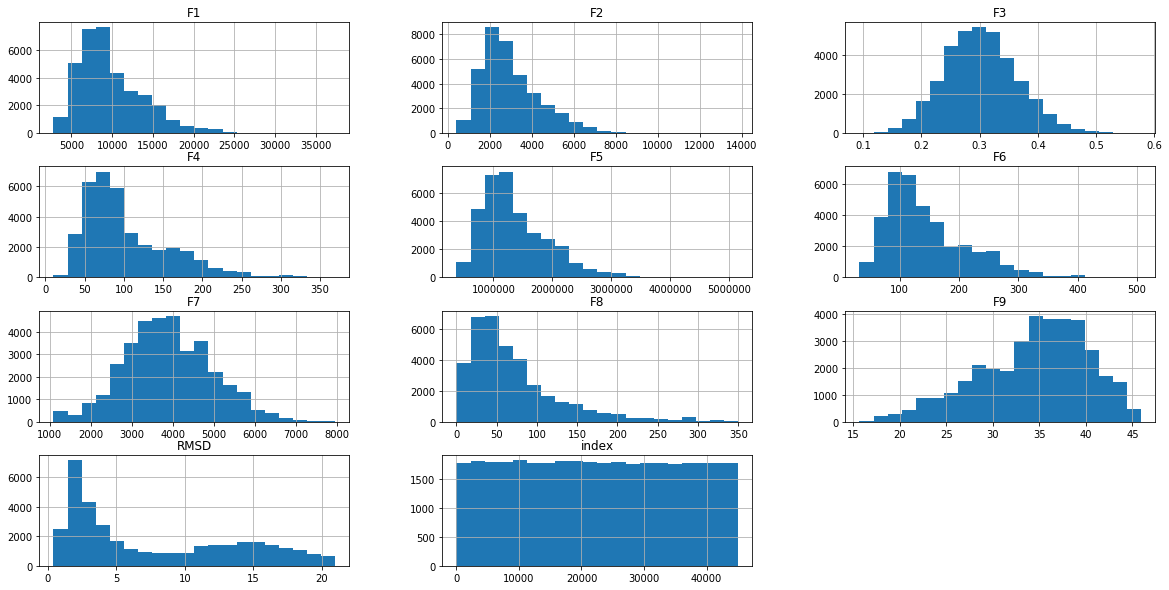

In [22]:
casp_train_set.hist(bins=20, figsize=(20,10));

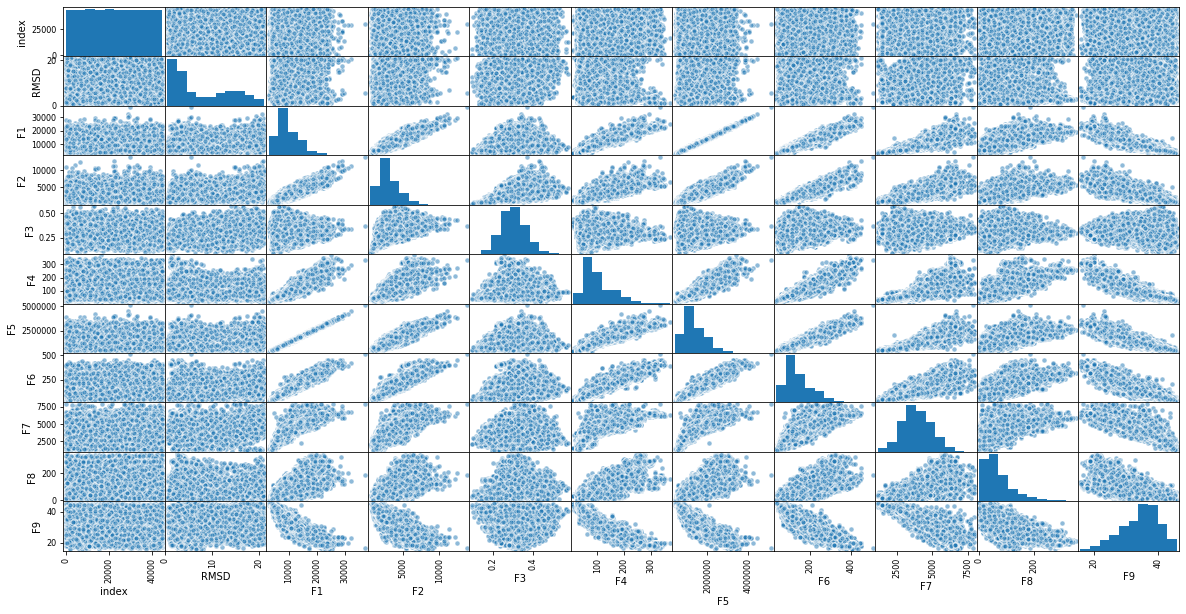

In [23]:
pd.plotting.scatter_matrix(casp_train_set, figsize=(20,10), edgecolors='w', s=100);

Split the data into training set and test set

In [24]:
X_train, y_train = casp_train_set.drop("RMSD", axis=1),casp_train_set["RMSD"]
X_test, y_test = casp_test_set.drop("RMSD", axis=1),casp_test_set["RMSD"]

The data exists on a different scales and we need to use a scaler model to fit it

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Regression

We can start with linear regression so that we have a baseline to compare the other models with.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Time taken 0.013664007186889648


In [41]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(5,5))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y_pred.min(),y_pred.max()],'k')
    plt.xlim(y_pred.min(),y_pred.max())
    plt.ylim(y_pred.min(),y_pred.max())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(round(r2_score(lin_reg_model.predict(X), y),2)))
    plt.savefig(name+'.svg', format='svg')

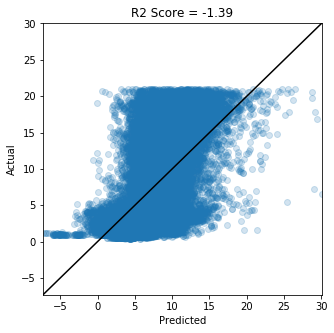

In [43]:
plot_results(X_train_scaled, y_train, lin_reg, "")

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X_train_scaled, y_train, scoring = "neg_mean_squared_error", cv=5)

In [50]:
def display_scores(scores):
    print("Scores: ", scores);
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [53]:
display_scores(np.sqrt(-scores))

Scores:  [5.10252533 5.11439348 5.18466881 5.06292223 5.13184408]
Mean:  5.119270786579085
Standard Deviation:  0.039785291939774654


Let us use the random forest regression model for this problem and see if that is better in terms of prediction accuracy

In [57]:
%timeit
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train);

In [59]:
scores= cross_val_score(forest_reg, X_train_scaled, y_train, scoring = "neg_mean_squared_error", cv=5)

In [60]:
display_scores(np.sqrt(-scores))

Scores:  [3.57286688 3.50659678 3.61599033 3.5506519  3.60906062]
Mean:  3.5710333013296647
Standard Deviation:  0.04009498463189088


In [34]:
X_test_scaled = scaler.fit_transform(X_test)

In [35]:
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  5.117367683769951 5.166514351255748


In [36]:
r2_model_score = r2_score(lin_reg.predict(X_test_scaled), y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

my_pipeline = Pipeline([
    ("poly_features", "passthrough"),
    ("scaler", "passthrough"),
    ("dim_reduction", "passthrough"),
    ("reg", "passthrough")
])

parameters = [
    {
        "scaler" : [MinMaxScaler()],
        "reg" : [RandomForestRegressor(n_estimators=100)]
    }
    #     },
#     {
#         "scaler" : [MinMaxScaler()],
#         "dim_reduction" : [PCA(n_components=0.99)],
#         "reg" : [MLPRegressor(max_iter=1000)],
#         "reg__hidden_layer_sizes": [100,200,500],
#         "reg__activation": ["relu"]
#     }
]

grid_search = GridSearchCV(my_pipeline, param_grid=parameters, cv=5, n_jobs=2, scoring="neg_mean_squared_error", return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
for scores, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(np.sqrt(-scores), params)

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_predicted = best_model.predict(X_train)

In [ ]:
mean_squared_error(y_predicted, y_train)

In [ ]:
plot_results(X_train, y_train, best_model, "Best Model")

In [ ]:
plot_results(X_test, y_test, best_model, "Best Model on test data")

# Fit a linear regression model

Let us start with linear regression model. As there is no linear correlation visible from the correlation plots, let us add some polynomial features to the dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp_cleaned.drop("RMSD", axis=1),casp_cleaned["RMSD"], test_size=0.3, random_state=42)

Let us start with splitting the dataset into training set and test set.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
print("Number of Features in the set " + str(X_train_scaled.shape[1]))

We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [ ]:
from sklearn.linear_model import LinearRegression
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

In [ ]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(5,5))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y_pred.min(),y_pred.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(round(r2_score(lin_reg_model.predict(X), y)),2))
    plt.savefig(name+'.svg', format='svg')

In [ ]:
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

In [ ]:
r2_model_score = r2_score(lin_reg.predict(X_test_scaled), y_test)

In [ ]:
plot_results(X_train_scaled, y_train, lin_reg, "Without_PCA_Train")

In [ ]:
plot_results(X_test_scaled, y_test, lin_reg, "Without_PCA_Test")

# Explore Other Models

At this point, we need to explore how other models will perform in better predicting the data. At this point, we cannot make any assumption about any model. Let us go ahead and test all the models on the dataset.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

my_pipeline = Pipeline([
    ("poly_features", "passthrough"),
    ("scaler", "passthrough"),
    ("dim_reduction", "passthrough"),
    ("reg", "passthrough")
])

parameters = [
    {
        "poly_features" : [PolynomialFeatures(degree=1), PolynomialFeatures(degree=3), PolynomialFeatures(degree=5)],
        "scaler" : [MinMaxScaler(), StandardScaler(), QuantileTransformer(), PowerTransformer(standardize=True), PowerTransformer(standardize=False)],
        "dim_reduction" : [PCA(n_components=0.99)],
        "reg" : [LinearRegression(), RandomForestRegressor(n_estimators=10), RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=500)]
    },
    {
        "scaler" : [MinMaxScaler(), StandardScaler(), QuantileTransformer(), PowerTransformer(standardize=True), PowerTransformer(standardize=False)],
        "dim_reduction" : [PCA(n_components=0.99)],
        "reg" : [MLPRegressor(max_iter=1000)],
        "reg__hidden_layer_sizes": [100,200,500],
        "reg__activation": ["tanh","relu"],
        "reg__solver": ["lbfgs","adam"],
        "reg__validation_fraction": [0.4,0.5]
    }
]

grid_search = GridSearchCV(my_pipeline, param_grid=parameters, cv=5, n_jobs=4, scoring="neg_mean_squared_error")

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
for scores, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(np.sqrt(-scores), params)

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_predicted = best_model.predict(X_train)

In [ ]:
mean_squared_error(y_predicted, y_train)

In [ ]:
plot_results(X_train, y_train, best_model, "Best Model")

In [ ]:
plot_results(X_test, y_test, best_model, "Best Model on test data")

In [ ]:
params = grid_search.cv_results_["params"]

In [ ]:
fp = open('params.txt', 'w')
for i in range(len(params)):
    fp.write(str(params[i])+'\n')
fp.close()